# Unit 6a - Adversarial ML

### Imports, functions and image plotting

Adversarial targets: tensor([6, 6, 7, 5, 2, 1, 2, 2, 9, 0])


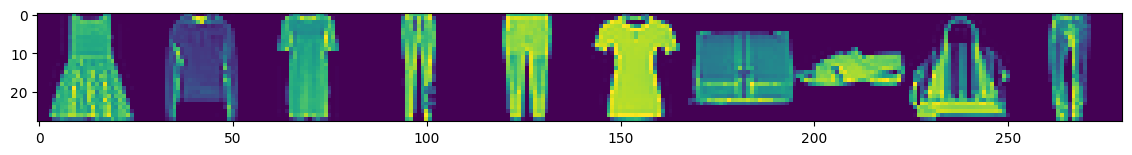

In [2]:
## basic server interaction
import json
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt


HOST = 'http://127.0.0.1:8000'
POST_HEADERS = {'Content-Type': 'application/octet-stream'}


def GET(path, **params):
    url = f"{HOST}/{path}"
    return requests.get(url, params=params)


def POST(path, data_bytes):
    url = f"{HOST}/{path}"
    return requests.post(url, data=data_bytes, headers=POST_HEADERS)


def activate(task, token):
    return GET("api/activate", task=task, token=token)


def handle_errors(response):
    if response.status_code != 200:
        print(response.content)
        raise RuntimeError(f"Unexpected HTTP status: {response.status_code}")


def evasion_get_challenge():
    response = GET("api/evasion/get_challenge")
    handle_errors(response)
    challenge = json.loads(response.content.decode("utf-8"))
    images = torch.tensor(np.array(challenge["images"], dtype=np.float32))
    targets = torch.tensor(challenge["targets"], dtype=torch.long)
    return images, targets


def evasion_solve_challenge(x_adv):
    data = x_adv.astype(np.float32).tobytes()
    response = POST("api/evasion/solve_challenge", data)
    handle_errors(response)
    token = response.text
    print(f"{token=}")
    return token


def stealing_get_challenge():
    response = GET("api/stealing/get_challenge")
    handle_errors(response)
    challenge = json.loads(response.content.decode("utf-8"))
    images = torch.tensor(np.array(challenge["images"], dtype=np.float32))
    return images


def stealing_solve_challenge(scores):
    data = scores.astype(np.float32).tobytes()
    response = POST("api/stealing/solve_challenge", data)
    handle_errors(response)
    token = response.text
    print(f"{token=}")
    return token


def predict(images):
    if not isinstance(images, np.ndarray) or images.dtype != np.float32:
        raise ValueError("Wrong format for images. Expected nd.array(dtype=np.float32)")
    response = POST("api/predict", images.tobytes())
    return response


# activate('evasion', 'Bry9sRljXXY8IElLjPLIoaQOSbXSXyq')
images, targets = evasion_get_challenge()
images_npy = images.numpy()

plt.figure(figsize=(14,14))
_ = plt.imshow(images_npy.transpose(0,2,1).transpose(2,0,1).reshape(28, -1)[:,:10*28])
print(f'Adversarial targets: {targets[:10]}')

## Stealing task

### Get our tensors

In [5]:
resp = predict(images_npy)
softmaxs = json.loads(resp.content.decode())['data']
softmaxs = np.array(softmaxs)
print(f'Predicted by API labels: {np.argmax(softmaxs[:10], axis=1)}')

gt_targets = torch.tensor(softmaxs)
gt_images = images
adv_targets = targets

type(gt_targets), type(gt_images), type(adv_targets)

Predicted by API labels: [3 2 3 1 1 0 8 5 8 1]


(torch.Tensor, torch.Tensor, torch.Tensor)

### Surrogate CNN

In [272]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define the surrogate model (same as the CustomCNN model)
class SurrogateCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SurrogateCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.dropout = nn.Dropout(0.5)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Add softmax layer

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        x = self.softmax(x)  # Apply softmax
        return x

### Enhanced surrogate CNN

In [141]:
# Define the enhanced surrogate model
class EnhancedSurrogateCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedSurrogateCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Add softmax layer

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 1 * 1)
        x = self.dropout1(self.relu5(self.fc1(x)))
        x = self.dropout2(self.relu6(self.fc2(x)))
        x = self.fc3(x)
        x = self.softmax(x)  # Apply softmax
        return x

### Train surrogate model

Epoch 1, Train Loss: 2.2924, Val Loss: 2.2964
Epoch 2, Train Loss: 2.2376, Val Loss: 2.2586


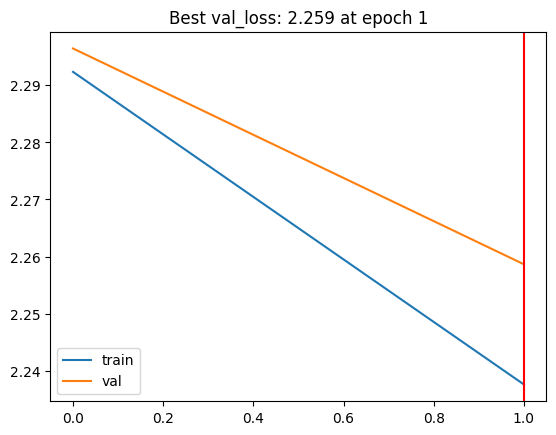

In [195]:
##### VARIABLES #####
num_epochs = 2
surrogate_model = EnhancedSurrogateCNN(num_classes=10)
best_model_path = 'best_enhanced_surrogate_model_1554.pt'
#####################

# Initialize the surrogate model, loss function, and optimizer
# criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence loss for matching softmax outputs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(surrogate_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, mode='triangular', cycle_momentum=False)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

# Dataset
inputs = images.unsqueeze(1)
softmax_outputs = gt_targets
dataset = TensorDataset(inputs, softmax_outputs)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop for the surrogate model
train_losses, val_losses = [], []
min_loss, best_epoch = np.inf, -1

for epoch in range(num_epochs):
    surrogate_model.train()
    running_loss = 0.0
    for inputs, softmax_outputs in train_loader:
        optimizer.zero_grad()
        outputs = surrogate_model(inputs).log_softmax(dim=1)  # Log-softmax for KL Divergence
        loss = criterion(outputs, softmax_outputs)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

    # Validation step
    surrogate_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, softmax_outputs in val_loader:
            outputs = surrogate_model(inputs).log_softmax(dim=1)
            loss = criterion(outputs, softmax_outputs)
            val_loss += loss.item()

    # Compute the losses
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the best model in case
    if val_loss < min_loss:
        min_loss = val_loss
        best_epoch = epoch
        torch.save(surrogate_model.state_dict(), best_model_path)

    # Update the lr
    # scheduler.step(val_loss)

# Load the best model
surrogate_model.load_state_dict(torch.load(best_model_path))

# Plot the loss
plt.plot(list(range(num_epochs)), train_losses, label='train')
plt.plot(list(range(num_epochs)), val_losses, label='val')
plt.axvline(best_epoch, c='r')
plt.legend()
_ = plt.title(f'Best val_loss: {min_loss:.3f} at epoch {best_epoch}')

## Prediction on test data

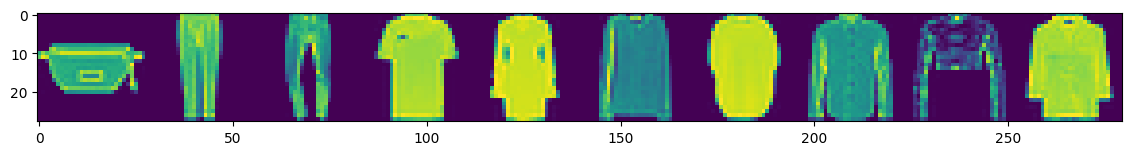

In [166]:
test_images = stealing_get_challenge()

plt.figure(figsize=(14,14))
_ = plt.imshow(test_images.numpy().transpose(0,2,1).transpose(2,0,1).reshape(28, -1)[:,:10*28])

In [167]:
# Load best model
best_model = 'Previous models/best_enhanced_surrogate_model_149.pt'
surrogate_model.load_state_dict(torch.load(best_model))

# Prediction
scores = surrogate_model(test_images.unsqueeze(1))
token = stealing_solve_challenge(scores.detach().numpy())

token='eyJub25jZSI6ICJJbXU3MFJIa1ArV3FjMENhSDhhV2xRPT0iLCAidG9rZW4iOiAidHpWTHR5N0dxc2JKZEhxbzkrS2hYOXE2TXZ6R0gvMUJoN3duZ0hWVmIzYjloZ0w3dTV4Q1owczV5Q2JQUWhEZnExSWJ6b2tUbUpkSEtDQkFLTUhuVlJnRU0ycDh4YnpRN2EwVkJkektraW1lYWJOSVNOdjYrNStSWWRLQkdNS3UwaktoQXc9PSIsICJ0YWciOiAidzBEUGVvbWFENUx1bWFzM0NvU3Y3Zz09In0='


## Evasion task 

### Generate adversarial examples

In [316]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


epsilons = [0, .05, .1, .15, .2, .25, .3]


# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, DataLoader(TensorDataset(images.unsqueeze(1), adv_targets), batch_size=32, shuffle=True), eps)
    accuracies.append(acc)
    examples.append(ex)



plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

RuntimeError: a Tensor with 32 elements cannot be converted to Scalar

In [323]:
# Load best model
# best_model = 'Previous models/best_enhanced_surrogate_model_149.pt' # 3.57%
# best_model = 'Previous models/best_enhanced_surrogate_model_1471.pt' # 3.57%
# best_model = 'Previous models/best_enhanced_surrogate_model_1435.pt' #
# best_model = 'Previous models/best_surrogate_model_168.pt' # 1.67%
best_model = 'best_surrogate_model_1569.pt' # 8.67%
# best_model = 'best_enhanced_surrogate_model_1554.pt' # 6.33%
# best_model = 'Previous models/best_enhanced_surrogate_model_157.pt' # 
# surrogate_model = SurrogateCNN(num_classes=10)
surrogate_model = EnhancedSurrogateCNN(num_classes=10)
surrogate_model2 = EnhancedSurrogateCNN(num_classes=10)

surrogate_model.load_state_dict(torch.load(best_model))
surrogate_model2.load_state_dict(torch.load(best_model))
surrogate_model2.eval()


# Function to create adversarial examples using FGSM
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    images = images.clone().detach().requires_grad_(True)
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

# Parameters
epsilon = .1

# Generate adversarial examples
surrogate_model.eval()
adv_examples = []

# Example target labels (replace with your actual target labels)
images, adv_targets = evasion_get_challenge()
target_labels = adv_targets

for sample, (input_, target_label) in enumerate(zip(images, adv_targets)):
    if sample % 50 == 0:
        print(sample)
    input_, target_label = input_.unsqueeze(0).unsqueeze(0), target_label.unsqueeze(0)

    i = 0
    predicted = -1
    while predicted != target_label and i < 10:
        perturbed_data = fgsm_attack(surrogate_model, nn.CrossEntropyLoss(), input_, target_label, epsilon)
        outputs = surrogate_model(perturbed_data)
        _, predicted = torch.max(outputs.data, 1)
        i += 1
        input_ = perturbed_data  # Update the input for the next iteration
        # print(outputs, predicted, target_label)

    adv_examples.append((perturbed_data, target_label))

# Evaluate the surrogate model on adversarial examples
correct = 0
total = 0

with torch.no_grad():
    for perturbed_data, target_label in adv_examples:
        outputs = surrogate_model(perturbed_data)
        _, predicted = torch.max(outputs.data, 1)
        total += target_label.size(0)
        correct += (predicted == target_label).sum().item()

print(f'Accuracy of the surrogate model on adversarial examples: {100 * correct / total:.2f}%')

0
50
100
150
200
250
Accuracy of the surrogate model on adversarial examples: 7.00%


In [324]:
x_adv = np.array([perturbed_data.squeeze().detach().numpy() for perturbed_data, _ in adv_examples])
x_adv.shape, type(x_adv)

((300, 28, 28), numpy.ndarray)

In [325]:
print(evasion_solve_challenge(x_adv))

token='eyJub25jZSI6ICJDSUNoM0IxWGdUek1mM3NHbDR4QzRRPT0iLCAidG9rZW4iOiAid002eTEzajJraC9JcmRwSVhQaGU1aUttZXhGVWpXQ29rWVVYVCs5MFNIUDBLeWV5RFdFOVRQNlRqTGRyQndqc29sd3FKQjlqVk8zSjBTbU5UOXBkRUUvcHMvYTZoYXY0OWthT2FNdDZEOE9yenNvcGpEQzJOQ093RExMTGtESzk4ZkpEMkNBaVNlYTdvZWp5cmFFdi92TDNmQjdQQTlBNU5jMmMrakNFSjBRRzRtRDdKMjFZaVlZdnJyL25aQ289IiwgInRhZyI6ICJBWFBIVDlUR2c4VUt4Z3dwNVhIZW13PT0ifQ=='
eyJub25jZSI6ICJDSUNoM0IxWGdUek1mM3NHbDR4QzRRPT0iLCAidG9rZW4iOiAid002eTEzajJraC9JcmRwSVhQaGU1aUttZXhGVWpXQ29rWVVYVCs5MFNIUDBLeWV5RFdFOVRQNlRqTGRyQndqc29sd3FKQjlqVk8zSjBTbU5UOXBkRUUvcHMvYTZoYXY0OWthT2FNdDZEOE9yenNvcGpEQzJOQ093RExMTGtESzk4ZkpEMkNBaVNlYTdvZWp5cmFFdi92TDNmQjdQQTlBNU5jMmMrakNFSjBRRzRtRDdKMjFZaVlZdnJyL25aQ289IiwgInRhZyI6ICJBWFBIVDlUR2c4VUt4Z3dwNVhIZW13PT0ifQ==


In [ ]:
eyJub25jZSI6ICJBYTQzbzNhRW02MjRJT2RpV1BkdmJRPT0iLCAidG9rZW4iOiAiZTBlemhIbCtwZW15dDYwalkzM095OGdGN1RUK05uOGt1UERFT3BacExuR0liSFBVbFkvdWkwMkx5OXhIQlpjNmFhMGR6NFpXUXRhRUtKcDY2ekwrbW0yZ3pZWXRPeTRBQnpGcHByRW1KbXNSOTc3RFpQbTBlYk04MUtmK0t3PT0iLCAidGFnIjogImN1dU0wcitMVEVEZC8vT1hWRmJtUlE9PSJ9